# 네이버 영화 리뷰 감성 분석

## 1. 데이터 준비와 확인

In [2]:
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import re
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt") # train
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt") # test
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt") # train + test

('ratings.txt', <http.client.HTTPMessage at 0x7ffaf1076510>)

In [4]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [5]:
train_data.info

<bound method DataFrame.info of               id                                           document  label
0        9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1        3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2       10265843                                  너무재밓었다그래서보는것을추천한다      0
3        9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4        6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1
...          ...                                                ...    ...
149995   6222902                                인간이 문제지.. 소는 뭔죄인가..      0
149996   8549745                                      평점이 너무 낮아서...      1
149997   9311800                    이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?      0
149998   2376369                        청춘 영화의 최고봉.방황과 우울했던 날들의 자화상      1
149999   9619869                           한국 영화 최초로 수간하는 내용이 담긴 영화      0

[150000 rows x 3 columns]>

In [6]:
test_data.info

<bound method DataFrame.info of             id                                           document  label
0      6270596                                                굳 ㅋ      1
1      9274899                               GDNTOPCLASSINTHECLUB      0
2      8544678             뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아      0
3      6825595                   지루하지는 않은데 완전 막장임... 돈주고 보기에는....      0
4      6723715  3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??      0
...        ...                                                ...    ...
49995  4608761          오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함      1
49996  5308387       의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO      0
49997  9072549                 그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다      0
49998  5802125     절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네      0
49999  6070594                                         마무리는 또 왜이래      0

[50000 rows x 3 columns]>

In [ ]:
!pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git 
%cd Mecab-ko-for-Google-Colab/
!bash install_mecab-ko_on_colab190912.sh
%cd ../

## 2. 데이터로더 구성

In [8]:
from konlpy.tag import Mecab
tokenizer = Mecab()

In [9]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [10]:
def tokenize_and_remove_stopwords(data, stopwords, tokenizer):
    result = []

    for sentence in data:
        curr_data = []
        curr_data = tokenizer.morphs(sentence)                                   # mecab 형태소 분석 tokenizer
        curr_data = [word for word in curr_data if not word in stopwords]        # 불용어 제거
        result.append(curr_data)
    return result 

In [11]:
def load_data(train_data, test_data, num_words=10000):

    # 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)

    # Nan 결측치 제거
    train_data = train_data.dropna(how='any')
    test_data = test_data.dropna(how='any')

    # 토큰화 및 불용어 제거
    x_train = tokenize_and_remove_stopwords(train_data['document'], stopwords, tokenizer)
    x_test = tokenize_and_remove_stopwords(test_data['document'], stopwords, tokenizer)

    # 단어장 만드는 중...
    words = np.concatenate(x_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    x_train = list(map(wordlist_to_indexlist, x_train))
    x_test = list(map(wordlist_to_indexlist, x_test))

    return x_train, np.array(list(train_data['label'])), x_test, np.array(list(test_data['label'])), word_to_index

In [12]:
x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)

In [1]:
print(y_test[10])

NameError: ignored

In [14]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [15]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
# 단, 모든 문장은 <BOS>로 시작하는 것을 말합니다.

def get_encoded_sentence(sentence, word_to_index):                                                        # 텍스트 -> 숫자
    return [word_to_index['<BOS>']] + [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해주는 함수입니다.
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):                                                # 숫자 -> 텍스트
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다.
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [16]:
get_decoded_sentence(x_train[10], index_to_word)

'. 진짜 짱 다 ♥'

## 3. 모델 구성을 위한 데이터 분석 및 가공

In [17]:
# 데이터 셋 내 문장 길이 분포
total_data_text = list(x_train) + list(x_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장 길이의 평균값, 최대값, 표준편차를 계산
print('문장길이 평균 :', np.mean(num_tokens))
print('문장길이 최대 :', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를 들면 최대길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) +2 * np.std(num_tokens)

maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens)/len(num_tokens)))

문장길이 평균 : 15.96938143432699
문장길이 최대 : 116
문장길이 표준편차 :  12.843571939469296
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [18]:
print(total_data_text[150000])

[28, 56, 6, 4, 4, 580, 1910, 526, 581, 677, 182, 4, 4, 86, 47, 16, 43]


In [19]:
print(total_data_text[150001])

[55, 128, 5, 3074, 26, 19, 32, 8, 12, 160, 2464, 266, 5, 14, 528]


In [20]:
# 패딩 추가
x_train = pad_sequences(x_train, value=word_to_index['<PAD>'], padding='pre', maxlen=maxlen)
x_test = pad_sequences(x_test, value=word_to_index['<PAD>'], padding='pre', maxlen=maxlen)

In [21]:
print(x_train.shape)
print(x_test.shape)

(146182, 41)
(49157, 41)


## 4. 모델 구성 및 validation 구성

In [22]:
vocab_size = 10000
word_vector_dim = 200                                                            # 2의 배수, 단어에 대한 차원 지정

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation = 'relu'))
model.add(keras.layers.Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 200)         2000000   
                                                                 
 lstm (LSTM)                 (None, 8)                 6688      
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


## 모델 훈련

In [23]:
x_val = x_train[:50000]
y_val = y_train[:50000]

partial_x_train = x_train[50000:]
partial_y_train = y_train[50000:]

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs= 100
history = model.fit(partial_x_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(x_val, y_val), verbose=1)

In [26]:
results = model.evaluate(x_test, y_test, verbose=2)

1537/1537 - 4s - loss: 1.9084 - accuracy: 0.8140 - 4s/epoch - 3ms/step


In [27]:
print(results)

[1.9083800315856934, 0.8139634132385254]


## 6. loss, accuracy 그래프 시각화

In [28]:
history_dict = history.history

print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [29]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

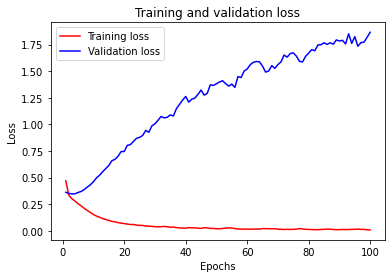

In [30]:
epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

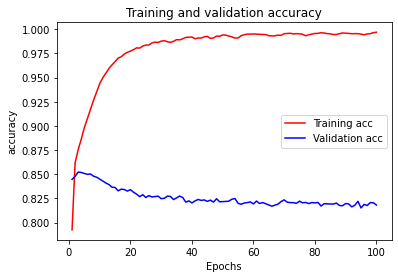

In [31]:
plt.clf() #그림을 초기화

plt.plot(epochs, acc, 'r-', label= 'Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# proj : 네이버 영화 리뷰 감성 분류에 SentencePiece 적용하기

- 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
- 학습된 모델로 sp_tokenize() 메소드 구현하기
- 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
- KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
- (보너스) SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기